#### **Adaptive RSAV definition**

In [1]:
# set the seed for reproducibility
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 

In [2]:
import torch
from torch.optim import Optimizer
import numpy as np
from autograd import grad, hessian
import matplotlib.pyplot as plt
from scipy.sparse import diags
import time

class AdaptiveRSAV(Optimizer):
    def __init__(self,
                 params, 
                 init_loss, 
                 lr, 
                 lr_max=100,
                 lr_min=0.01, 
                 C=0, 
                 opL='trival', 
                 eta=0.99, 
                 rho=1.1, 
                 gamma=0.9, 
                 adaptive=True,
                 tol=1e-6):
        
        modified_energy = torch.sqrt(init_loss + C)
        defaults = dict(r=modified_energy, ME=modified_energy, lr=lr, lr_max=lr_max, lr_min=lr_min, C=C, opL=opL, eta=eta, rho=rho, gamma=gamma, adaptive=adaptive, tol=tol)
        super().__init__(params, defaults)
        self.loss = init_loss

    def step(self, closure=None, k=0):
        """Performs a single optimization step."""
        for group in self.param_groups:
            # adaptive step size according to the modified energy
            indicator = group['r'] / group['ME']
            # indicator = 1 - abs(indicator - 1)
            if not group['adaptive']:
                pass
            elif indicator < group['gamma'] and group['lr'] > group['lr_min']:
                group['lr'] = max(indicator * group['lr'], group['lr_min'])
            else:
                group['lr'] = group['rho'] * group['lr']
           
            # set the operator L
            if group['opL'] == "trival":
                # flatten the group parameters and gradients
                self.loss.backward()
                r_tilde = sum([p.grad.norm()**2 for p in group['params']]) / (group['ME']**2)
                r_tilde = group['r'] / (1 + group['lr'] * r_tilde / 2)
                for p in group['params']:
                    p.data -= group['lr'] * r_tilde * p.grad / group['ME']
            elif group['opL'] == "diag_hessian":
                # flatten the group parameters and gradients
                params_flatten = torch.cat([p.view(-1) for p in group['params']])
                grad1 = torch.autograd.grad(self.loss, group['params'], create_graph=True)
                grad_flatten = torch.cat([p.view(-1) for p in grad1])
                grad2 = []
                # calculate the diagonal of Hessian matrix
                # here we've calculate the whole Hessian matrix
                # TODO: calculate the diagonal of Hessian matrix without calculating the whole Hessian matrix
                for (g, x) in zip(grad1, group['params']):
                    hessian = torch.zeros_like(x)
                    for index in np.ndindex(*g.shape):
                        hessian[index] = (torch.autograd.grad(g[index], x, retain_graph=True)[0][index])
                    grad2.append(hessian.detach_())
                diag_L = torch.cat([p.view(-1) for p in grad2])
                # update params
                g = grad_flatten / group['ME']
                hat_g = (1 / (group['lr'] * diag_L + 1)) * g
                r_tilde = group['r'] / (1 + group['lr'] * torch.dot(g, hat_g) / 2)
                params_flatten = params_flatten - group['lr'] * r_tilde * hat_g

                # update group['params']
                start = 0
                for p in group['params']:
                    end = start + p.numel()
                    p.data = params_flatten[start:end].view(p.shape)
                    start = end
            else:
                raise ValueError("Invalid value for opL: {}".format(group['opL']))

            # update modefied energy (ME) and scalar auxilary variable (r)
            self.loss = closure()
            group['ME'] = torch.sqrt(self.loss + group['C'])
            if group['ME'] != r_tilde:
                xi = (group['ME'] - torch.sqrt((1-group['eta']) * r_tilde**2 + group['eta'] * group['r']**2 + (1-group['eta']) * (r_tilde-group['r'])**2)) / (group['ME'] - r_tilde)
                xi = max(xi, 0)
            else:
                xi = 0
            group['r'] = xi * r_tilde + (1 - xi) * group['ME']
            
        return self.loss.item()

#### **Adaptive RSAV testing**

##### **Test 1: Approxiamte nonlinear function by MLP**

Consider $u(x,t)$ defined on $[0,1]\times[0,1]$,
$$
u(x,t) = \sin(\pi x) e^{-t}.
$$

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from d2l import torch as d2l
import matplotlib.animation as animation

class MaxAbsErrorLoss(torch.nn.Module):
    def __init__(self):
        super(MaxAbsErrorLoss, self).__init__()

    def forward(self, prediction, target):
        return torch.max(torch.abs(prediction - target))

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(2, 50)
        self.hidden2 = torch.nn.Linear(50, 50)
        self.predict = torch.nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.predict(x)
        return x

In [4]:
def reset(lr=1, lr_min=0.001, C=1e-6, opL='diag_hessian', seed=0):
    # coordinates
    x = np.linspace(0, 1, 100)
    time_points = np.linspace(0, 1, 100)
    x, time_points = np.meshgrid(x, time_points)
    x = x.flatten()[:,None]
    time_points = time_points.flatten()[:,None]

    # function to approximate
    u = np.sin(np.pi*x)*(1-np.exp(-time_points))

    x = torch.tensor(x, dtype=torch.float)
    time_points = torch.tensor(time_points, dtype=torch.float)
    xt = torch.cat([x,time_points],1)
    u = torch.tensor(u, dtype=torch.float)

    setup_seed(seed)
    net = Net()
    # loss_func = torch.nn.MSELoss()
    loss_func = MaxAbsErrorLoss()
    prediction = net(xt)
    loss = loss_func(prediction, u)
    optimizer = AdaptiveRSAV(net.parameters(), init_loss=loss, lr=lr, lr_min=lr_min, C=C, opL=opL)
    return xt, u, net, loss_func, optimizer

def plot_loss(cost, logy=False):
    if logy:
        plt.semilogy(cost)
    else:
        plt.plot(cost)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

def plot_uexact_prediction(xt, u, prediction):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot([i[0] for i in xt], [i[1] for i in xt], np.squeeze(prediction.detach().numpy()), color=(1, 0, 0, 0.5), label = "Prediction")
    ax.plot([i[0] for i in xt], [i[1] for i in xt], np.squeeze(u.detach().numpy()), color=(0, 0, 1, 0.5), label = "Ground Truth")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$u(x,t)$')
    ax.set_zlim([-.1, .7])  # Set the limits for the z-axis
    ax.text2D(0.05, 0.95, f"Iteration: {i+1}", transform=ax.transAxes)  # Add iteration number
    ax.legend()

The infinity norm of the error is: 0.0066356360912323


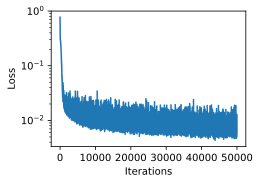

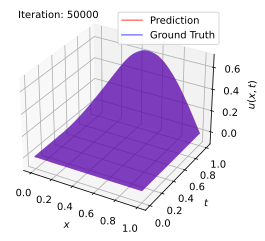

In [8]:
xt, u, net, loss_func, optimizer = reset(lr=0.01, lr_min=0.01, C=0, opL='trival', seed=0)
from torch.optim import Adam, SGD
# optimizer = SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)    
optimizer = Adam(net.parameters(), lr=0.001)
iter_num = 50000
animator = d2l.Animator(xlabel='epoch', xlim=[1, iter_num], legend=['loss'])
    
def closure():   
    prediction = net(xt)
    loss = loss_func(prediction, u)
    return loss

def update(i):
    prediction = net(xt)
    loss = loss_func(prediction, u)
    if progress:
        animator.add(i+1, loss.item())
    else:
        err.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if plot_animation:
        ax.clear()
        ax.plot([i[0] for i in xt], [i[1] for i in xt], np.squeeze(prediction.detach().numpy()), color=(1, 0, 0, 0.5), label = "Prediction")
        ax.plot([i[0] for i in xt], [i[1] for i in xt], np.squeeze(u.detach().numpy()), color=(0, 0, 1, 0.5), label = "Ground Truth")
        ax.set_xlabel('$x$')
        ax.set_ylabel('$t$')
        ax.set_zlabel('$u(x,t)$')
        ax.set_zlim([-.1, .7])  # Set the limits for the z-axis
        ax.text2D(0.05, 0.95, f"Iteration: {i+1}", transform=ax.transAxes)  # Add iteration number
        ax.legend()

plot_animation, progress = False, False
err = []
for i in range(iter_num):
    update(i)
prediction = net(xt)

print(f"The infinity norm of the error is: {closure()}")
plot_loss(err, logy=True)
plot_uexact_prediction(xt, u, prediction)

# plot_fig = True
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ani = animation.FuncAnimation(fig, update, frames=range(iter_num), repeat=False, interval=50)
# ani.save('animation.gif', writer='pillow')
# plt.show()

The infinity norm of the error is: 0.006189167499542236


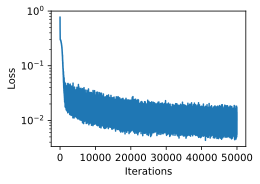

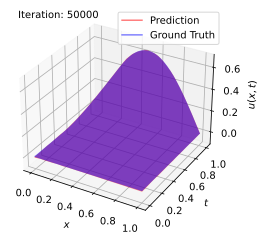

In [ ]:
xt, u, net, loss_func, optimizer = reset(lr=0.01, lr_min=0.01, C=0, opL='trival', seed=0)
from torch.optim import Adam, SGD
optimizer = SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)    
# optimizer = Adam(net.parameters(), lr=0.001)
iter_num = 50000
animator = d2l.Animator(xlabel='epoch', xlim=[1, iter_num], legend=['loss'])
    
def closure():   
    prediction = net(xt)
    loss = loss_func(prediction, u)
    return loss

def update(i):
    prediction = net(xt)
    loss = loss_func(prediction, u)
    if progress:
        animator.add(i+1, loss.item())
    else:
        err.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if plot_animation:
        ax.clear()
        ax.plot([i[0] for i in xt], [i[1] for i in xt], np.squeeze(prediction.detach().numpy()), color=(1, 0, 0, 0.5), label = "Prediction")
        ax.plot([i[0] for i in xt], [i[1] for i in xt], np.squeeze(u.detach().numpy()), color=(0, 0, 1, 0.5), label = "Ground Truth")
        ax.set_xlabel('$x$')
        ax.set_ylabel('$t$')
        ax.set_zlabel('$u(x,t)$')
        ax.set_zlim([-.1, .7])  # Set the limits for the z-axis
        ax.text2D(0.05, 0.95, f"Iteration: {i+1}", transform=ax.transAxes)  # Add iteration number
        ax.legend()

plot_animation, progress = False, False
err = []
for i in range(iter_num):
    update(i)
prediction = net(xt)

print(f"The infinity norm of the error is: {closure()}")
plot_loss(err, logy=True)
plot_uexact_prediction(xt, u, prediction)

# plot_fig = True
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ani = animation.FuncAnimation(fig, update, frames=range(iter_num), repeat=False, interval=50)
# ani.save('animation.gif', writer='pillow')
# plt.show()

The infinity norm of the error is: 0.042795076966285706


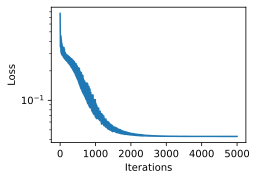

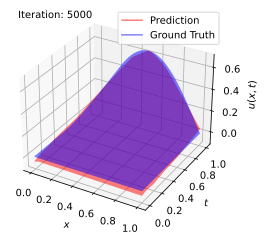

In [7]:
xt, u, net, loss_func, optimizer = reset(lr=0.01, lr_min=0.01, C=0, opL='trival', seed=0)
# xt, u, net, loss_func, optimizer = reset(lr=1, lr_min=0.01, C=1e-6, opL='diag_hessian', seed=0)
iter_num = 5000
animator = d2l.Animator(xlabel='epoch', xlim=[1, iter_num], legend=['loss'])
    
def closure():   
    prediction = net(xt)
    loss = loss_func(prediction, u)
    return loss

def update(i):
    prediction = net(xt)
    loss = loss_func(prediction, u)
    if progress:
        animator.add(i+1, loss.item())
    else:
        err.append(loss.item())
    optimizer.zero_grad()
    optimizer.step(closure)
    if plot_animation:
        ax.clear()
        ax.plot([i[0] for i in xt], [i[1] for i in xt], np.squeeze(prediction.detach().numpy()), color=(1, 0, 0, 0.5), label = "Prediction")
        ax.plot([i[0] for i in xt], [i[1] for i in xt], np.squeeze(u.detach().numpy()), color=(0, 0, 1, 0.5), label = "Ground Truth")
        ax.set_xlabel('$x$')
        ax.set_ylabel('$t$')
        ax.set_zlabel('$u(x,t)$')
        ax.set_zlim([-.1, .7])  # Set the limits for the z-axis
        ax.text2D(0.05, 0.95, f"Iteration: {i+1}", transform=ax.transAxes)  # Add iteration number
        ax.legend()

plot_animation, progress = False, False
err = []
for i in range(iter_num):
    update(i)
prediction = net(xt)

print(f"The infinity norm of the error is: {closure()}")
plot_loss(err, logy=True)
plot_uexact_prediction(xt, u, prediction)

# plot_fig = True
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ani = animation.FuncAnimation(fig, update, frames=range(iter_num), repeat=False, interval=50)
# ani.save('animation.gif', writer='pillow')
# plt.show()

In [ ]:
pass_2 = 0
pass_1 = 0
from tqdm import tqdm
for _ in tqdm(range(100)):
    xt, u, net, loss_func, optimizer = reset(lr=0.01, lr_min=0.01, C=1e-10, opL='trival', seed=0)
    iter_num = 5000

    def closure():   
        prediction = net(xt)
        loss = loss_func(prediction, u)
        return loss

    def update(i):
        prediction = net(xt)
        loss = loss_func(prediction, u)
        optimizer.step(closure)

    for i in range(iter_num):
        update(i)
    prediction = net(xt)
    if closure() <= 0.2:
        pass_2 += 1
        if closure() <= 0.1:
            pass_1 += 1
print(pass_1, pass_2)

##### **Test 2: Convex and Nonconvex loss function**

In [3]:
# define cost function
def f(x):
    return torch.sum(x[1::2]**2) + torch.sum(x[::2]**2) / 100

# define Rosenbrock function
a, b = 1, 100
def rosenbrock(x):
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2

9.706453268832003e-21


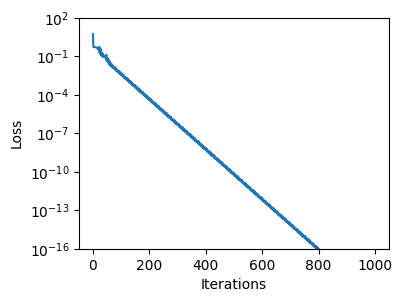

In [4]:
# theta = torch.tensor([-3.0,-4.0], requires_grad=True)
# func = rosenbrock
theta = torch.ones(100, requires_grad=True, dtype=torch.float64, device='cuda:0')
func = f
def closure():
    loss = func(theta)
    return loss

# optimizer = AdaptiveRSAV([theta], init_loss=func(theta), lr=1, lr_min=0.001, C=1e-6, opL='trival', adaptive=True)
# optimizer = AdaptiveRSAV([theta], init_loss=func(theta), lr=0.01, lr_min=0.01, C=1, opL='diag_hessian', adaptive=True)
from sav import ARSAV
optimizer = ARSAV([theta], init_loss=func(theta), lr=1, lr_min=0.01, C=0, opL='trivial', adaptive=True)
# optimizer = ARSAV([theta], init_loss=func(theta), lr=0.01, lr_min=0.01, C=1, opL='diag_hessian', adaptive=True)

# cost = np.zeros(1000)
# for i in range(1000):
#     cost[i] = closure()
#     optimizer.step(closure)

cost = np.zeros(1000)
for i in range(1000):
    optimizer.zero_grad()
    cost[i] = optimizer.step(closure)

# optimizer = torch.optim.Adam([theta], lr=0.006)

# cost = np.zeros(1000)
# for i in range(1000):
#     optimizer.zero_grad()
#     loss = closure()
#     loss.backward()
#     cost[i] = loss.item()
#     optimizer.step()

print(closure().item())

plt.figure(figsize=(4, 3))
plt.semilogy(cost)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim(1e-16, 1e2)
plt.show()

9.392301947041091e-88


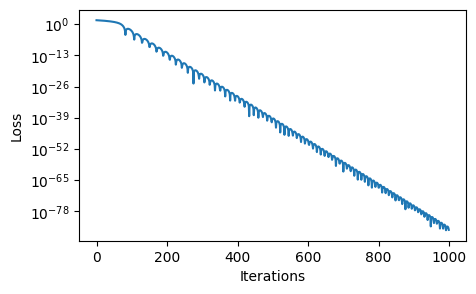

In [5]:
from adam_rsav import Adam_SAV
import math

theta = torch.ones(100, requires_grad=True, dtype=torch.float64, device='cuda:0')
func = f
def closure():
    optimizer.zero_grad()
    loss = func(theta)
    loss.backward()
    return loss

learning_rate = 0.01
C = 1
res = 0.
r = torch.sqrt(func(theta) + C)
optimizer = Adam_SAV([theta], lr=learning_rate, r=r, res=res, c=C, l=4, weight_decay=1e-4)
# optimizer = torch.optim.Adam([theta], lr=0.006)

cost = np.zeros(1000)
for i in range(1000):
    cost[i] = optimizer.step(closure)[0].item()
    
print(closure().item())

plt.figure(figsize=(5, 3))
plt.semilogy(cost)
plt.xlabel('Iterations')
plt.ylabel('Loss')
# plt.ylim(10e-4, 10e5)
plt.show()

##### **Test 3: Phase retrieval**

(256, 256)

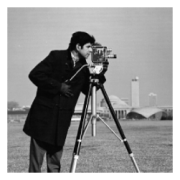

In [121]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from scipy import ndimage

img = Image.open(r'D:\OneDrive - sjtu.edu.cn\github\Code-reproduction\Original-256256-cameraman-image_W640.jpg')
img_gray = np.array(img.convert('L'))
img_gray = ndimage.zoom(img_gray, 256 / 640)
plt.figure(figsize=(3, 3))
plt.imshow(img_gray, cmap='gray')
plt.axis('off');
img_gray.shape

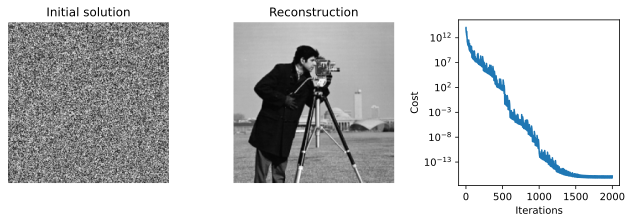

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
z_exact = torch.from_numpy(img_gray.flatten()).to(device).double() / 256
# generate mask vercters M_i
m, N = 6, 256 ** 2
setup_seed(0)
masks = torch.randn(m, N).double().to(device)

def A(z):
    result = masks * z
    result = torch.fft.fft(result, dim = 1)
    result = torch.abs(result) ** 2
    return result.flatten()

b = A(z_exact)
# initial solution
z = torch.rand(N, dtype=torch.float64).to(device)
z.requires_grad = True
def loss_func():
    return torch.linalg.norm(A(z) - b) ** 2
plt.figure(figsize=(11, 3))
plt.subplot(1, 3, 1)
plt.imshow(z.reshape(256, 256).detach().cpu(), cmap='gray')
plt.axis('off');
plt.title('Initial solution')
# optimizer = torch.optim.Adam([z], lr=0.001, betas=(0.8, 0.9))
# optimizer = torch.optim.SGD(tnn.parameters(), lr=0.003, momentum=0.9, nesterov=True)
optimizer = AdaptiveRSAV([z], init_loss=loss_func(), lr=1, lr_min=0.001, C=0, opL='trival')
iterations = 2000
cost = np.zeros(iterations)
for i in range(iterations):
    optimizer.zero_grad()
    cost[i] = optimizer.step(loss_func, i)
    
z = z.reshape(256, 256).detach().cpu()
plt.subplot(1, 3, 2)
plt.imshow(z, cmap='gray')
plt.axis('off');
plt.title('Reconstruction')
plt.subplot(1, 3, 3)
plt.semilogy(cost)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.subplots_adjust(wspace=0.4)
plt.show()

In [123]:
max(abs(z.flatten() - z_exact.cpu()))

tensor(2.6298e-14, dtype=torch.float64)

#### **Elementwise RSAV**

##### **E_RSAV: autograd version**

In [192]:
import torch
from torch.optim import Optimizer
import numpy as np
from autograd import grad, hessian
import matplotlib.pyplot as plt
from scipy.sparse import diags

class AE_RSAV_autograd(Optimizer):
    def __init__(self,
                 params, 
                 init_loss, 
                 lr, 
                 lr_max=100,
                 lr_min=0.01, 
                 C=0, 
                 opL='trival', 
                 eta=0.95, 
                 rho=1.1, 
                 gamma=0.9, 
                 adaptive=True,
                 tol=1e-6):
        
        modified_energy = torch.sqrt(init_loss + C)
        self.loss = init_loss
        self.device = init_loss.device
        self.dtype = init_loss.dtype
        defaults = dict(ME=modified_energy, lr=lr, lr_max=lr_max, lr_min=lr_min, C=C, opL=opL, eta=eta, rho=rho, gamma=gamma, adaptive=adaptive, tol=tol)
        super().__init__(params, defaults)
        for group in self.param_groups:
            total_params = sum(p.numel() for p in group['params'])
            group['r'] = torch.ones(total_params, device=self.device, dtype=self.dtype) * modified_energy
            group['params_prev'] = None

    def step(self, closure=None, k=0):
        """Performs a single optimization step."""
        for group in self.param_groups:
            if group['ME'] == 0:
                print('Optimization stops at iteration:', k)
                print("Modified energy is zero! If loss does not attain minimum, please try to increase the value of C.")
                stop_optim = True
                return self.loss.item(), stop_optim
            # adaptive step size according to the modified energy
            indicator = torch.mean(group['r'] / group['ME'])
            # indicator = 1 - abs(indicator - 1)
            if not group['adaptive']:
                pass
            elif indicator < group['gamma'] and group['lr'] > group['lr_min']:
                group['lr'] = max(indicator * group['lr'], group['lr_min'])
            else:
                group['lr'] = group['rho'] * group['lr']

            # flatten the group parameters and gradients
            params_flatten = torch.cat([p.view(-1) for p in group['params']]).detach()
            group['params_prev'] = params_flatten.clone()
            
            # set the operator L
            if group['opL'] == "trival":
                grad1 = torch.autograd.grad(self.loss, group['params'])
                grad_flatten = torch.cat([p.view(-1) for p in grad1])
                grad_flatten.detach_()
                # update params
                # print(grad_flatten, group['ME'])
                g = grad_flatten / group['ME']
                r_tilde = group['r'] / (1 + group['lr'] * g ** 2 / 2)
                # print(g, r_tilde)
                params_flatten -= group['lr'] * r_tilde * g
                # print(params_flatten)
            elif group['opL'] == "diag_hessian":
                grad1 = torch.autograd.grad(self.loss, group['params'], create_graph=True)
                grad_flatten = torch.cat([p.view(-1) for p in grad1])
                grad2 = []
                # calculate the diagonal of Hessian matrix
                # here we've calculate the whole Hessian matrix
                # TODO: calculate the diagonal of Hessian matrix without calculating the whole Hessian matrix
                for (g, x) in zip(grad1, group['params']):
                    hessian = torch.zeros_like(x)
                    for index in np.ndindex(*g.shape):
                        hessian[index] = (torch.autograd.grad(g[index], x, retain_graph=True)[0][index])
                    grad2.append(hessian.detach_())
                diag_L = torch.cat([p.view(-1) for p in grad2])
                # update params
                g = grad_flatten / group['ME']
                hat_g = (1 / (group['lr'] * diag_L + 1)) * g
                r_tilde = group['r'] / (1 + group['lr'] * torch.dot(g, hat_g) / 2)
                params_flatten = params_flatten - group['lr'] * r_tilde * hat_g
            else:
                raise ValueError("Invalid value for opL: {}".format(group['opL']))

            # update group['params']
            start = 0
            for p in group['params']:
                end = start + p.numel()
                p.data = params_flatten[start:end].view(p.shape)
                start = end
            
            # update modefied energy (ME) and scalar auxilary variable (r)
            loss = closure()
            self.loss = loss[0] if isinstance(loss, (tuple, list)) else loss
            with torch.no_grad():
                group['ME'] = torch.sqrt(self.loss + group['C'])
                xi = group['ME'] - r_tilde
                indices = torch.where(xi != 0)
                xi[indices] = (group['ME'] - torch.sign(xi)[indices] * torch.sqrt(r_tilde[indices]**2 + group['eta'] / group['lr'] * (params_flatten[indices] - group['params_prev'][indices])**2)) / xi[indices]
                xi = xi.clamp_min(0)
                group['r'] = xi * r_tilde + (1 - xi) * group['ME']

        return self.loss.item(), False

##### **E-RSAV: backward version**

In [187]:
import torch
from torch.optim import Optimizer
import numpy as np
from autograd import grad, hessian
import matplotlib.pyplot as plt
from scipy.sparse import diags

class AE_RSAV_backward(Optimizer):
    def __init__(self,
                 params, 
                 init_loss, 
                 lr, 
                 lr_max=100,
                 lr_min=0.01, 
                 C=0, 
                 opL='trival', 
                 eta=0.95, 
                 rho=1.1, 
                 gamma=0.9, 
                 adaptive=True,
                 tol=1e-6):
        
        modified_energy = torch.sqrt(init_loss + C)
        self.loss = init_loss
        self.device = init_loss.device
        self.dtype = init_loss.dtype
        defaults = dict(ME=modified_energy, lr=lr, lr_max=lr_max, lr_min=lr_min, C=C, opL=opL, eta=eta, rho=rho, gamma=gamma, adaptive=adaptive, tol=tol)
        super().__init__(params, defaults)
        for group in self.param_groups:
            total_params = sum(p.numel() for p in group['params'])
            group['r'] = torch.ones(total_params, device=self.device, dtype=self.dtype) * modified_energy
            group['params_prev'] = torch.ones(total_params, device=self.device, dtype=self.dtype)

    def step(self, closure=None, k=0):
        """Performs a single optimization step."""
        for group in self.param_groups:
            if group['ME'] == 0:
                print('Optimization stops at iteration:', k)
                print("Modified energy is zero! If loss does not attain minimum, please try to increase the value of C.")
                stop_optim = True
                return self.loss.item(), stop_optim
            # adaptive step size according to the modified energy
            indicator = torch.mean(group['r'] / group['ME'])
            # indicator = 1 - abs(indicator - 1)
            if not group['adaptive']:
                pass
            elif indicator < group['gamma'] and group['lr'] > group['lr_min']:
                group['lr'] = max(indicator * group['lr'], group['lr_min'])
            else:
                group['lr'] = group['rho'] * group['lr']
            
            # set the operator L
            if group['opL'] == "trival":
                self.loss.backward()
                # update params
                # print(grad_flatten, group['ME'])
                r_tilde = torch.zeros_like(group['r'], device=self.device, dtype=self.dtype)
                params_flatten = torch.zeros_like(group['r'], device=self.device, dtype=self.dtype)
                start = 0
                for p in group['params']:
                    end = start + p.numel()
                    group['params_prev'][start:end] = p.detach().view(-1)
                    # TODO: group['r'][start:end] does not match the size of p.grad
                    r_tilde_ = group['r'][start:end] / (1 + group['lr'] * p.grad.pow(2) / (group['ME']**2) / 2)
                    p.data -= group['lr'] * r_tilde_ * p.grad / group['ME']
                    r_tilde[start:end] = r_tilde_                    
                    params_flatten[start:end] = p.detach().view(-1)
                    start = end
            elif group['opL'] == "diag_hessian":
                # flatten the group parameters and gradients
                params_flatten = torch.cat([p.view(-1) for p in group['params']]).detach()
                group['params_prev'] = params_flatten.clone()

                grad1 = torch.autograd.grad(self.loss, group['params'], create_graph=True)
                grad_flatten = torch.cat([p.view(-1) for p in grad1])
                grad2 = []
                # calculate the diagonal of Hessian matrix
                # here we've calculate the whole Hessian matrix
                # TODO: calculate the diagonal of Hessian matrix without calculating the whole Hessian matrix
                for (g, x) in zip(grad1, group['params']):
                    hessian = torch.zeros_like(x)
                    for index in np.ndindex(*g.shape):
                        hessian[index] = (torch.autograd.grad(g[index], x, retain_graph=True)[0][index])
                    grad2.append(hessian.detach_())
                diag_L = torch.cat([p.view(-1) for p in grad2])
                # update params
                g = grad_flatten / group['ME']
                hat_g = (1 / (group['lr'] * diag_L + 1)) * g
                r_tilde = group['r'] / (1 + group['lr'] * torch.dot(g, hat_g) / 2)
                params_flatten = params_flatten - group['lr'] * r_tilde * hat_g

                # update group['params']
                start = 0
                for p in group['params']:
                    end = start + p.numel()
                    p.data = params_flatten[start:end].view(p.shape)
                    start = end
            else:
                raise ValueError("Invalid value for opL: {}".format(group['opL']))
          
            # update modefied energy (ME) and scalar auxilary variable (r)
            loss = closure()
            self.loss = loss[0] if isinstance(loss, (tuple, list)) else loss
            with torch.no_grad():
                group['ME'] = torch.sqrt(self.loss + group['C'])
                xi = group['ME'] - r_tilde
                indices = torch.where(xi != 0)
                xi[indices] = (group['ME'] - torch.sign(xi)[indices] * torch.sqrt(r_tilde[indices]**2 + group['eta'] / group['lr'] * (params_flatten[indices] - group['params_prev'][indices])**2)) / xi[indices]
                xi = xi.clamp_min(0)
                group['r'] = xi * r_tilde + (1 - xi) * group['ME']
                
        return self.loss.item(), False

##### **Test 1: Convex loss function**

$$
f\left(\theta_1, \theta_2, \ldots, \theta_{2N}\right)=\sum_{i=1}^{N} \theta_{2 i-1}^2+\sum_{i=1}^{N} \frac{1}{2N} \theta_{2 i}^2 .
$$

Max theta: tensor(0., dtype=torch.float64, grad_fn=<UnbindBackward0>)
Loss: tensor(3.1352e-162, dtype=torch.float64, grad_fn=<AddBackward0>)


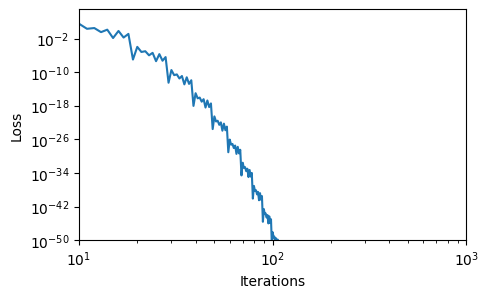

In [ ]:
# define cost function
def f(x):
    return torch.sum(x[1::2]**2) + torch.sum(x[::2]**2) / 100
theta = torch.ones(100, requires_grad=True, dtype=torch.float64)
func = f

def closure():
    loss = func(theta)
    return loss

optim = AE_RSAV_autograd
# optim = AE_RSAV_backward
optimizer = optim([theta], init_loss=func(theta), lr=20, lr_min=0.001, C=0, opL='trival', adaptive=False)
cost = np.zeros(300)
for i in range(300):
    optimizer.zero_grad()
    cost[i], stop_optim = optimizer.step(closure)
    if stop_optim: break

print('Max theta:', max(theta))
print('Loss:', closure())

plt.figure(figsize=(5, 3))
plt.loglog(cost)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim(1e-50, 1e5)
plt.xlim(1e1, 1e3)
plt.show()

##### **Test 2: Phase retrieval**

(256, 256)

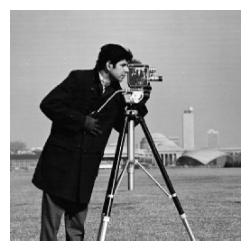

In [79]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from scipy import ndimage

img = Image.open(r'D:\OneDrive - sjtu.edu.cn\github\Code-reproduction\Original-256256-cameraman-image_W640.jpg')
img_gray = np.array(img.convert('L'))
img_gray = ndimage.zoom(img_gray, 256 / 640)
plt.figure(figsize=(3, 3))
plt.imshow(img_gray, cmap='gray')
plt.axis('off');
img_gray.shape

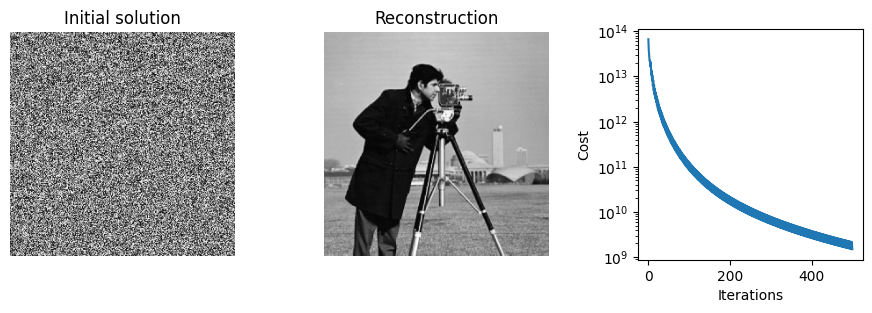

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
z_exact = torch.from_numpy(img_gray.flatten()).to(device).double() / 256
# generate mask vercters M_i
m, N = 6, 256 ** 2
setup_seed(0)
masks = torch.randn(m, N).double().to(device)

def A(z):
    result = masks * z
    result = torch.fft.fft(result, dim = 1)
    result = torch.abs(result) ** 2
    return result.flatten()

b = A(z_exact)
# initial solution
z = torch.rand(N, dtype=torch.float64).to(device)
z.requires_grad = True
def loss_func():
    return torch.linalg.norm(A(z) - b) ** 2
plt.figure(figsize=(11, 3))
plt.subplot(1, 3, 1)
plt.imshow(z.reshape(256, 256).detach().cpu(), cmap='gray')
plt.axis('off');
plt.title('Initial solution')
# optimizer = torch.optim.Adam([z], lr=0.001, betas=(0.8, 0.9))
# optimizer = torch.optim.SGD(tnn.parameters(), lr=0.003, momentum=0.9, nesterov=True)
optim = AE_RSAV_autograd
# optim = AE_RSAV_backward
optimizer = optim([z], init_loss=loss_func(), lr=1e-11, lr_min=1e-13, C=0, opL='trival', adaptive=False)
cost = np.zeros(500)
for i in range(500):
    optimizer.zero_grad()
    cost[i], _ = optimizer.step(loss_func, i)
z = z.reshape(256, 256).detach().cpu()
plt.subplot(1, 3, 2)
plt.imshow(z, cmap='gray')
plt.axis('off');
plt.title('Reconstruction')
plt.subplot(1, 3, 3)
plt.semilogy(cost)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.subplots_adjust(wspace=0.4)
plt.show()

In [162]:
max(abs(z.flatten() - z_exact.cpu()))

tensor(0.1156, dtype=torch.float64)